In [1]:
%%capture

import imp
from statistics import mode
import torch 
from torchvision import transforms
import argparse
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

# parser = argparse.ArgumentParser()


# parser.add_argument('--img', metavar='img', type=str ,
#                     help = "Image to Cartoonize")

# args = parser.parse_args()


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_DIM      = 512
lr           = 2e-4
MAPS_GEN     = 64
MAPS_DISC    = 64
IMG_CHANNELS = 3
L1_LAMBDA    = 100


Trasforms = transforms.Compose([
    transforms.Resize(IMG_DIM),
    transforms.CenterCrop(IMG_DIM),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5))
    ])
torch.load('../weights/Cartoonify_Generator.pt',map_location=torch.device(DEVICE))



FileNotFoundError: [Errno 2] No such file or directory: '../weights/Cartoonify_Generator.pt'

In [2]:
%%capture

import torch
import torch.nn as nn
import os

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'


class convblock(nn.Module):
    def __init__(self, in_channels, out_channels,activation , conv_architecture , batch_norm, drop_out ,*args, **kwargs):
        super(convblock, self).__init__()
        
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.conv_architecture = conv_architecture
        # print(self.conv_architecture)

        self.activations =  nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2)],
            ['relu', nn.ReLU()],
            ['tanh', nn.Tanh()]
        ])

# Module dict just does not works when taking keyword args
        if self.conv_architecture == "Regular" : 
            self.conv =  nn.Conv2d(self.in_channels, self.out_channels , kernel_size=4, stride=2, padding = 1, bias = False, *args, **kwargs)
        
        if self.conv_architecture == "Transposed" :
            self.conv  = nn.ConvTranspose2d(self.in_channels, self.out_channels , kernel_size=4, stride=2, padding = 1 , bias = False, *args, **kwargs)


        self.batch_norms = nn.ModuleDict([
            ['Yes', nn.BatchNorm2d(self.out_channels)],
            ['No', nn.Identity()]

        ])

        self.dropouts = nn.ModuleDict([
            ['Yes', nn.Dropout(0.5)],
            ['No', nn.Identity()],


        ])
        self.l1 = nn.Sequential(
            self.conv,
            self.batch_norms[batch_norm],
            self.activations[activation],
            self.dropouts[drop_out]
        )


    def forward(self,x):
        x = self.l1(x)
        return x
    

    
class Generator(nn.Module):
    def __init__(self, img_channels, features):
        super(Generator, self).__init__()
        self.img_channels = img_channels

        # --------------------------------------------------ENCODER# --------------------------------------------------#
        self.e1 = convblock(in_channels=self.img_channels, out_channels=features,  padding_mode = 'reflect', 
            activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')

        self.e2 = convblock(in_channels=features, out_channels=features * 2, padding_mode = 'reflect', 
            activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')

        self.e3 = convblock(in_channels=features * 2, out_channels=features * 4, padding_mode = 'reflect', 
             activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')

        self.e4 = convblock(in_channels=features * 4 ,out_channels=features * 8 , padding_mode = 'reflect', 
            activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')

        self.e5 = convblock(in_channels=features * 8 ,out_channels=features * 8 , padding_mode = 'reflect', 
            activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')
        
        self.e6 = convblock(in_channels=features * 8 ,out_channels=features * 8 , padding_mode = 'reflect', 
            activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')
        
        self.e7 = convblock(in_channels=features * 8 ,out_channels=features * 8 , padding_mode = 'reflect', 
            activation='lrelu', conv_architecture='Regular', batch_norm='Yes', drop_out='No')
        # BotltleNeck Layer
        self.e8 = convblock(in_channels=features * 8 ,out_channels=features * 8 ,
            activation='relu', conv_architecture='Regular', batch_norm='No', drop_out='No')


        # --------------------------------------------------DECODER# --------------------------------------------------#
        self.d1 = convblock(in_channels=features * 8, out_channels=features * 8, 
            activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='Yes')

        self.d2 = convblock(in_channels=features * 8 * 2 , out_channels=features * 8,
            activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='Yes')

        self.d3 = convblock(in_channels=features * 8 * 2 , out_channels=features * 8,
             activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='Yes')

        self.d4 = convblock(in_channels=features * 8 * 2 , out_channels=features * 8,
            activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='No')

        self.d5 = convblock(in_channels=features * 8 * 2,out_channels=features * 4 ,
            activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='No')
        
        self.d6 = convblock(in_channels=features * 4 * 2 ,out_channels=features * 2 ,
            activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='No')
        
        self.d7 = convblock(in_channels=features * 2 * 2 ,out_channels=features ,
            activation='relu', conv_architecture='Transposed', batch_norm='Yes', drop_out='No')
        # Final Layer
        self.d8 = convblock(in_channels=features * 2 ,out_channels=self.img_channels ,
            activation='tanh', conv_architecture='Transposed', batch_norm='No', drop_out='No')

        
    def forward(self,  x):
        # Encoding Imaege
        e1 = self.e1(x)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        e5 = self.e5(e4)
        e6 = self.e6(e5)
        e7 = self.e7(e6)
        # BottleNeck
        e8 = self.e8(e7)

        # Decoding Image
        d1 = self.d1(e8)
        d2 = self.d2(torch.cat([d1, e7], 1 ))
        d3 = self.d3(torch.cat([d2, e6], 1 ))
        d4 = self.d4(torch.cat([d3, e5], 1 ))
        d5 = self.d5(torch.cat([d4, e4], 1 ))
        d6 = self.d6(torch.cat([d5, e3], 1 ))
        d7 = self.d7(torch.cat([d6, e2], 1 ))
        d8 = self.d8(torch.cat([d7, e1], 1 ))

        return d8

In [3]:
# %%capture
from glob import glob
import random
from PIL import Image

files = glob('../data/face/*.jpg')
file_ = random.choices(files, k = 3)


print(file_)

['../data/face/1532.jpg', '../data/face/5160.jpg', '../data/face/9864.jpg']


In [4]:

model = Generator(img_channels=3, features=64)
model.load_state_dict(torch.load('../weights/Cartoonify_Generator.pt',map_location=torch.device(DEVICE)))
model.eval()

# create figure
fig = plt.figure(figsize=(20, 20))
rows = 3
columns = 3

# Adds a subplot at the 1st position
i = 1
for img_path in file_:    
    img = Image.open(img_path)
    gt = Image.open(img_path.replace('face', 'comics'))
    img2 = Trasforms(img)
    gt2 = Trasforms(gt)
    
    out = model(img2.unsqueeze(0).to(DEVICE))
    img_grid_fake = make_grid(out[:8], normalize=True)
    img_grid_fake = img_grid_fake.cpu().detach().numpy()
    out = np.transpose(img_grid_fake,(1,2,0))
    
    # Adds a subplot at the 1st position
    
    fig.add_subplot(rows, columns, i)

    # showing image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Real Face")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(gt)
    plt.axis('off')
    plt.title("Ground Truth")

    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, i+2)

    # showing image
    plt.imshow(out)
    plt.axis('off')
    plt.title("Generated")
    
    i = i+3

    

FileNotFoundError: [Errno 2] No such file or directory: '../weights/Cartoonify_Generator.pt'

In [ ]:
from torchvision.utils import make_grid
img_grid_fake = make_grid(fake_image[:8], normalize=True)

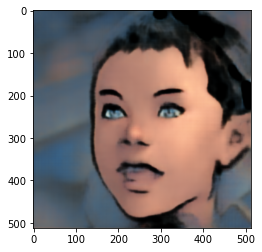

In [ ]:
img_grid_fake = img_grid_fake.cpu().detach().numpy()
plt.imshow(np.transpose(img_grid_fake,(1,2,0)))